In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

## 訓練データの読み込み

In [24]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [25]:
# 性別を変換する（訓練データ）
# gemder=pd.get_dummies(df_train.loc[:,['Gender']])
# df_train['Female']=gemder.loc[:,['Gender_Female']]
# df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.drop(columns=['Age'],inplace=True)
df_train.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [26]:
df_train.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706
std,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226
min,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000
25%,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000
50%,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000
75%,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000
max,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000


# 評価データの読み込み

In [27]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [28]:
# 性別を変換する（検証データ）
# gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
# df_vat['Female']=gemder.loc[:,['Gender_Female']]
# df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.drop(columns=['Age'],inplace=True)
df_vat.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


## データを加工する

In [29]:
def xConv(x_tmp):
    # T_Bilの変換
    bins = [0, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 100]
    x_tmp=comCutCnnect2(x_tmp, bins, 'T_Bil')

    # D_Bilの変換
    bins = [0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 100]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'D_Bil' )
    
    # ALPの変換
    bins = [0, 200, 210, 220, 225, 230, 300, 350, 600 , 2500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALP' )
    
    # ALT_GPTの変換
    bins = [0,  10, 12.5, 15, 17.5, 20, 22.5, 25, 50, 100, 1500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALT_GPT' )
    
    # AST_GOTの変換
    bins = [0, 20, 25, 30, 40, 50, 60, 1000]
    x_tmp=comCutCnnect2(x_tmp, bins, 'AST_GOT' )

    # TPの変換
    bins = [0, 5.5, 6, 6.5, 7, 75, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'TP' )
    
    # Albの変換
    bins = [0, 2.5, 2.8, 3.3, 3.8, 4.5, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'Alb' )

    # AG_ratioの変換
    bins = [0, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'AG_ratio' )
    
    # Ageの変換の変換
#    bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
#    x_tmp=comCutCnnect(x_tmp,  bins, 'Age' )
        
    return x_tmp


def comCutCnnect(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
    cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
    
    df=pd.DataFrame(cutTemp ,columns=[col + str(x) for x in range(cutTemp.shape[1])])
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, df], axis=1)

    return x_tmp 

def comCutCnnect2(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, X_cut], axis=1)

    return x_tmp 

In [30]:
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures


#### 訓練データのデータ加工前処理

In [31]:
# 説明変数（訓練データ）
#x_tmp=xConv(df_train.loc[:,['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio', 'Female', 'Male']])
#x_tmp=xConv(df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']])
x_tmp=df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']]

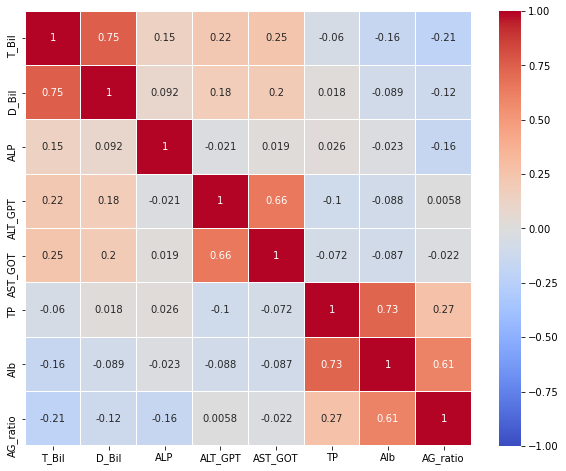

In [32]:
# seabornライブラリをsnsという省略名でインポート
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(x_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [37]:
mask = []
def comSelectot(x, y, col):
    
    global mask
    
    # 組み込み法に使うモデルの指定
    fs_model = LogisticRegression(penalty='l2', random_state=0)
    # 閾値の指定
    fs_threshold = "mean"
    # 組み込み法モデルの初期化
    selector = SelectFromModel(fs_model, threshold=fs_threshold)


    # 特徴量生成
    polynomial = PolynomialFeatures(degree=3, include_bias=False)
    polynomial_arr = polynomial.fit_transform(np.array(x))
    # polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
    X_polynomial = pd.DataFrame(polynomial_arr, columns=[col + str(x_) for x_ in range(polynomial_arr.shape[1])])

    # 特徴量選択の実行
    selector.fit(X_polynomial, y_train)
    mask = selector.get_support()

    # 選択された特徴量だけのサンプル取得
    X_polynomial_masked = X_polynomial.loc[:, mask]
    return X_polynomial_masked
    
    

In [38]:
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])

x_SelTem1 = np.array(x_tmp.loc[:,['ALP', 'ALT_GPT', 'AST_GOT']])
x_SelTem2 = np.array(x_tmp.loc[:,['T_Bil', 'D_Bil']])

X_polynomial_masked1=comSelectot(x_SelTem1 ,y_train,'polya')
mask1 = mask
X_polynomial_masked2=comSelectot(x_SelTem2 ,y_train,'polyb')
mask2 = mask


X_polynomial_masked = pd.concat([X_polynomial_masked1, X_polynomial_masked2], axis=1) 

x_train = np.array(X_polynomial_masked)




C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [40]:
mask1

array([False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False])

In [41]:
print(X_polynomial_masked)

            polya3        polya12        polya15        polya17    polyb0  \
0     48478.655820   39935.288281    2442.712240    6358.871999  0.786886   
1     48937.586178  576144.392983  132912.277976  213976.330739  1.003987   
2    102893.734942   51127.906854    2012.312019   11831.741018  0.657140   
3    136366.359430  435658.654699   40521.833183  102058.711088  0.906822   
4     49631.830562   94291.120518    8707.349465  594627.736739  1.734959   
..             ...            ...            ...            ...       ...   
845   46507.564630   42047.094886    2722.458659    5675.591182  0.767450   
846   45714.833572   45353.217445    3089.365526    5897.326178  0.867946   
847   53056.553062  377723.946624   66406.028027   99708.235071  0.826785   
848   45868.957039   69764.266040    5879.093881   53505.331919  0.761972   
849   46104.897533   54185.017007    4008.745867    9762.074255  0.762713   

       polyb1    polyb2  
0    0.150498  0.619190  
1    0.195625  1.007990

In [42]:
X_polynomial_masked.describe()

,polya3,polya12,polya15,polya17,polyb0,polyb1,polyb2
count,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,850.000000,850.000000,850.000000
mean,1.141913e+05,5.225137e+06,2.701302e+07,7.463401e+06,1.607337,0.606737,8.547614
std,3.889466e+05,4.126780e+07,2.451896e+08,5.497577e+07,2.443585,1.569032,39.679509
min,2.665443e+04,3.501515e+03,6.044482e+01,9.058295e+02,0.585961,0.034861,0.343350
25%,4.579233e+04,4.162272e+04,2.540318e+03,6.466057e+03,0.781258,0.144889,0.610365
50%,4.844071e+04,6.552227e+04,4.605782e+03,1.419220e+04,0.835591,0.194085,0.698213
75%,5.265002e+04,1.506461e+05,1.225627e+04,6.554528e+04,1.196759,0.335447,1.432468
max,4.445704e+06,4.509293e+08,2.882607e+09,6.162836e+08,23.017027,17.692164,529.783523


In [43]:
X_polynomial_masked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   polya3   850 non-null    float64
 1   polya12  850 non-null    float64
 2   polya15  850 non-null    float64
 3   polya17  850 non-null    float64
 4   polyb0   850 non-null    float64
 5   polyb1   850 non-null    float64
 6   polyb2   850 non-null    float64
dtypes: float64(7)
memory usage: 46.6 KB


#### 評価データのデータ加工前処理

In [44]:
# 説明変数（評価データ）
x_tmp=xConv(df_vat)

In [45]:
def comSelectot2(x,  col,mask):
    
    # 組み込み法に使うモデルの指定
    fs_model = LogisticRegression(penalty='l2', random_state=0)
    # 閾値の指定
    fs_threshold = "mean"
    # 組み込み法モデルの初期化
    selector = SelectFromModel(fs_model, threshold=fs_threshold)

    # 特徴量生成
    polynomial = PolynomialFeatures(degree=3, include_bias=False)
    polynomial_arr = polynomial.fit_transform(np.array(x))
    
    # polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
    X_polynomial = pd.DataFrame(polynomial_arr, columns=[col + str(x_) for x_ in range(polynomial_arr.shape[1])])

    # 選択された特徴量だけのサンプル取得
    X_polynomial_masked = X_polynomial.loc[:, mask]
    return X_polynomial_masked
    

In [47]:

x_SelTem1 = np.array(x_tmp.loc[:,['ALP', 'ALT_GPT', 'AST_GOT']])
x_SelTem2 = np.array(x_tmp.loc[:,['T_Bil', 'D_Bil']])

X_polynomial_masked1=comSelectot2(x_SelTem1 ,'polya',mask1)
X_polynomial_masked2=comSelectot2(x_SelTem2 ,'polyb',mask2)

X_polynomial_masked = pd.concat([X_polynomial_masked1, X_polynomial_masked2], axis=1) 

x_vat = np.array(X_polynomial_masked)


In [49]:
#y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
#y[np.arange(len(y_train)), y_train.T] = 1
#y_train = y
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [50]:
# 標準化
#from sklearn.preprocessing import StandardScaler,MinMaxScaler
#sc = StandardScaler() 
#norm = MinMaxScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)
#X_vat=sc.transform(x_vat)

In [51]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(x_vat).float()

In [52]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)


torch.Size([637, 7])
torch.Size([213, 7])


In [53]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([637, 1])

In [54]:
print(X_vat.shape)


torch.Size([350, 7])


In [55]:
# x と y の値をひとつの変数に格納する
train = TensorDataset(X_train ,Y_train)

In [56]:
# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(train ,batch_size=30, shuffle=True)

In [80]:
node1=150
node2=100
node3=60
node4=20


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node4)         # nn.Linear (入力のノード数 , 中間層ノード数)
#        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
#        self.fc3 = nn.Linear(node2 , node3)           # nn.Linear (中間層ノード数 , 中間層ノード数)
#        self.fc4 = nn.Linear(node3 , node4)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc5 = nn.Linear(node4,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid (self.fc1(x))               # 入力のノードを中間層（１階層目）に渡して結果を得る
#        y = torch.sigmoid(self.fc2(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
#        y = torch.sigmoid(self.fc3(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
#        y = torch.sigmoid(self.fc4(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc5(y))            # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        #return F.log_softmax(y , dim=0)
        return y

In [81]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
#criterion = nn.MSELoss()
# 損失の定義 (平均二乗誤差)
criterion = nn.BCELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [82]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.005)
#optimizer = optim.SGD(model.parameters() , lr=0.001)

In [83]:
loss_list = []
loss_temp = 0
logdisp=10
# トレーニングの回数分ループする。
for epoch in range(200):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_list.append(loss.item()/(logdisp*len(train_loader)))
        print(f'Epoch {epoch+1} Loss {loss.item()/(logdisp*len(train_loader))} -- {loss_temp}')
        loss_temp = 0

Epoch 10 Loss 0.0036403187296607277 -- 134.39669799804688
Epoch 20 Loss 0.001746628772128712 -- 122.71318054199219
Epoch 30 Loss 0.0018137727271426809 -- 120.38990783691406
Epoch 40 Loss 0.0024061967026103625 -- 119.68852233886719
Epoch 50 Loss 0.002703508734703064 -- 119.40786743164062
Epoch 60 Loss 0.0015804313800551674 -- 119.00923919677734
Epoch 70 Loss 0.0014140726490454241 -- 118.07470703125
Epoch 80 Loss 0.005003618110309947 -- 119.25672912597656
Epoch 90 Loss 0.0015644758939743042 -- 118.2142105102539
Epoch 100 Loss 0.0012274994091554122 -- 117.75591278076172
Epoch 110 Loss 0.0033005424521186134 -- 117.90467071533203
Epoch 120 Loss 0.002309061722321944 -- 117.45591735839844
Epoch 130 Loss 0.0015030970627611334 -- 116.89166259765625
Epoch 140 Loss 0.0009576133029027419 -- 117.17281341552734
Epoch 150 Loss 0.0029848529533906417 -- 116.810546875
Epoch 160 Loss 0.0013268083333969117 -- 117.92847442626953
Epoch 170 Loss 0.0029971125451001253 -- 117.3453140258789
Epoch 180 Loss 0.002

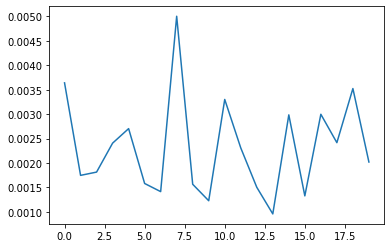

In [84]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [85]:
#print(Y_test)

In [86]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
###   # テストデータｘに対する結果　（値の大きい方を取得する）
###   y_hat = torch.max(model(x).data ,1)[1]
###   y_true = torch.max(y ,1)[1]
###   # テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
###   accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
###   print(accuracy)
###   print(y_hat.numpy())
###   print(y_true.data.numpy())

y_hat=model(x).data
y_true=Y_test.numpy()
accuracy = np.sum(Y_test.numpy() == y_hat.round().numpy()) /len(Y_test.numpy())
print(accuracy)


0.7981220657276995


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

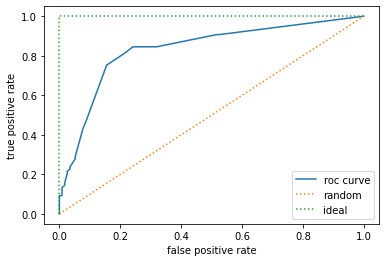

[1.9986975  0.99869746 0.9975896  0.9239156  0.9108015  0.9049263
 0.9032731  0.8698614  0.86768764 0.8576758  0.8334378  0.808865
 0.79159075 0.7435217  0.7401658  0.646291   0.6241124  0.5984273
 0.5363591  0.48546264 0.4047784  0.40477315 0.28386208 0.21344985
 0.16466841 0.1600681 ]


In [87]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [88]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8330963384287238


#  予測する

In [89]:
###   y_predict = torch.max(model(X_vat).data ,1)[1]
###   df_out = pd.DataFrame(np.array(y_predict.detach().numpy().copy(),dtype=np.int64), columns=['val'])
y_predict = model(X_vat).data
print(y_predict)
y_predict = y_predict.round().numpy()
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.int64), columns=['val'])

print(df_out)
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


tensor([[0.9744],
        [0.3526],
        [0.9171],
        [0.9826],
        [0.9923],
        [0.9601],
        [0.9112],
        [0.9741],
        [0.9704],
        [0.9865],
        [0.9847],
        [0.4827],
        [0.9973],
        [0.9929],
        [0.9754],
        [0.6088],
        [0.4430],
        [0.9011],
        [0.8669],
        [0.9376],
        [0.9937],
        [0.9749],
        [0.7983],
        [0.9723],
        [0.9365],
        [0.5171],
        [0.9741],
        [0.8062],
        [0.9738],
        [0.9977],
        [0.8828],
        [0.9943],
        [0.8442],
        [0.6715],
        [0.9837],
        [0.8014],
        [0.9751],
        [0.9834],
        [0.9459],
        [0.9103],
        [0.4821],
        [0.9937],
        [0.9903],
        [0.9732],
        [0.8872],
        [0.9752],
        [0.9524],
        [0.6154],
        [0.5744],
        [0.9690],
        [0.9908],
        [0.9938],
        [0.9937],
        [0.9779],
        [0.9985],
        [0

# モデルの保存

In [91]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)